In [5]:
# %%
'''
 # @ Author: Baptiste Royer
 # @ Create Time: 2022-05-25 17:40:11
 # @ Modified by: Baptiste Royer
 # @ Modified time: 2023-02-28 15:00:17
 # @ Description:
 '''

# %load_ext autoreload
# %autoreload 1
from qutip import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm
π = np.pi

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

### Define  operators

In [6]:
#%%% cavity operators
Ncav = 100
a = destroy(Ncav)
ad = dag(a)
n = ad*a
idCav = qeye(Ncav)

#%%% qubit operators
id2 = qeye(2)
sx = sigmax()
sy = sigmay()
sz = sigmaz()
sm = destroy(2)
sp = dag(sm)
Pg = (id2 + sz)/2
Pe = (id2 - sz)/2
pState = (basis(2) + basis(2,1)).unit()

In [7]:
# Symmetric controlled diplacements
def CD(alpha):
    return tensor(Pg,displace(Ncav,alpha/2)) + tensor(Pe,displace(Ncav,-alpha/2))

# Qubit rotation around Z
def Rz(phi):
    return tensor((-1j/2*phi*sz).expm(),idCav)

# Qubit rotation around Y (instead of Hadamard)
def Ry(theta):
    return tensor((-1j/2*theta*sy).expm(),idCav)

Rypi2 = Ry(π/2) # Y pi/2 rotation

### Single trajectory test

Set initial state

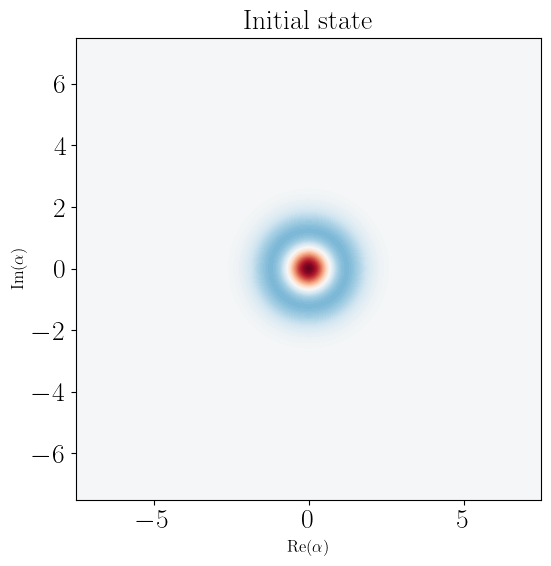

In [8]:
#psi = basis(Ncav)           # Example with the vacuum state
psi = fock(Ncav,1)         # example with fock 1
plot_wigner(psi)
plt.title('Initial state');

Measuring limit: x =  6.283185307179586
Momentum estimate: 0.69552


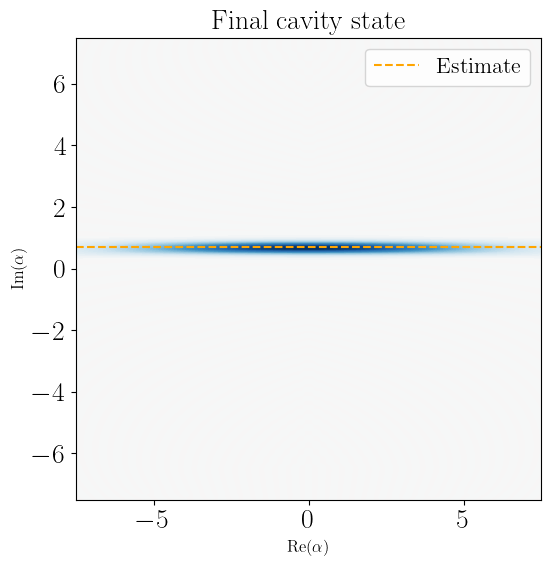

In [9]:
epsilon = 0.5               # Value for the controlled displacement, sets the maximum measurement range
Nmeas = 60                  # Code is set-up such that we perform 2Nmeas measurements, Nm for the real and Nm for the imaginary part

CDespilon = CD(epsilon)
measRecordR = np.empty(Nmeas)
measRecordI = np.empty(Nmeas)
print("Measuring limit: x = ", π/epsilon)

for i in range(2*Nmeas):
    # Phase Estimtation algorithm
    psic = tensor(pState,psi) # Tensor cavity state with qubit + state
    psic = CDespilon*psic
    psic = Rz(π/2*(i%2))*psic                   # Measure half the time the real part, and half the time the imaginary part
    psic = Rypi2*psic                           # Equivalent to Hadamard if measurement is right after
    probg = expect(tensor(Pg,idCav),psic)       # Probability to measure the qubit in g
    # Flip coin for qubit measurement and collapse state onto qubit measurement result
    if np.random.rand() < probg:
        meas = 0
        psi = tensor(basis(2).dag(),idCav)*psic
        psi = psi.unit()
    else:
        meas = 1
        psi = tensor(basis(2,1).dag(),idCav)*psic
        psi = psi.unit()

    # Record measurement in the right round
    if i%2 == 0:
        measRecordR[i//2] = meas
    else:
        measRecordI[i//2] = meas

# Estimate the probabilities of qubit measurements from recorded measurements
pr = np.mean(measRecordR)
pi = np.mean(measRecordI)

#Estimate the momentum from recorded measurements. Don't forget the sqrt2 from the difference between displacements and translations
estimate = 1/np.sqrt(2)/epsilon*np.angle(2*pr-1-1j*(2*pi - 1))
print("Momentum estimate: {:.5f}".format(estimate))

# %%
plot_wigner(psi)
plt.plot([-7.5,7.5],np.full(2,estimate),'--',c='orange', label='Estimate')
plt.title('Final cavity state')
plt.legend();

Note the cavity state has been heavily squeezed due to projection onto a quadrature.

### Same simulation, but multiple trajectories

In [10]:
epsilon = 0.5
CDespilon = CD(epsilon)
Nmeas = 50
Ntraj = 500
trajEstimates = []

print("Measuring limit = ", π/epsilon)

for j in tqdm(range(Ntraj)):
    psi = fock(Ncav, 1)
    measRecordR = np.empty(Nmeas)
    measRecordI = np.empty(Nmeas)

    for i in range(2*Nmeas):
        psic = tensor(pState,psi)
        psic = CDespilon*psic
        psic = Rz(π/2*(i%2))*psic
        psic = Rypi2*psic
        probg = expect(tensor(Pg,idCav),psic)
        # probe = expect(tensor(Pe,idCav),psic)
        if np.random.rand() < probg:
            meas = 0
            psi = tensor(basis(2).dag(),idCav)*psic
            psi = psi.unit()
        else:
            meas = 1
            psi = tensor(basis(2,1).dag(),idCav)*psic
            psi = psi.unit()

        if i%2 == 0:
            measRecordR[i//2] = meas
        else:
            measRecordI[i//2] = meas

    pr = np.mean(measRecordR)
    pi = np.mean(measRecordI)
    estimate = 1/np.sqrt(2)/epsilon*np.angle(2*pr-1-1j*(2*pi - 1))
    trajEstimates.append(estimate)
print("Final photon number in cavity: {:.3f}".format(expect(n, psi)))

Measuring limit =  6.283185307179586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:18<00:00,  6.34it/s]

Final photon number in cavity: 9.744


Note that the final photon number is higher than the initial.

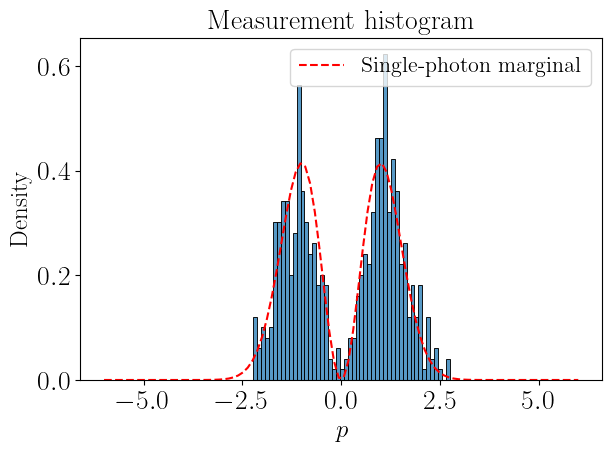

In [17]:
fig, ax = plt.subplots()
sns.histplot(data=(np.array(trajEstimates)),ax=ax,kde=False,stat="density",bins=50)
x = np.linspace(-6,6,100)

#ax.plot(x, np.abs(np.exp(-x**2/2)*(1/π)**(1/4))**2) # vacuum
ax.set_title('Measurement histogram')
ax.plot(x, np.abs((2/np.sqrt(2))*np.exp(-x**2/2)*(1/π)**(1/4)*x)**2, 'r--', label='Single-photon marginal'); # 1 photon
ax.set_xlabel('$p$')
plt.legend();
plt.tight_layout()
#plt.savefig('phase_est_1photon.pdf')